# Proyek Klasifikasi Gambar: [vegetables-dataset]
- **Nama:** [Muhamad Akmal Athallah]
- **Email:** [akmal7604@gmail.com/ mc006d5y1912@student.devacademy.id]
- **ID Dicoding:** [mc006d5y1912]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [4]:
import os  
import shutil  

# Path dataset asal  
dataset_path = r"D:\UB\Dicoding\Datasets\vegetable"  

# Path dataset tujuan  
target_dataset_path = r"D:\UB\Dicoding\Datasets\vegetable\dataset"  

# Buat folder dataset jika belum ada  
os.makedirs(target_dataset_path, exist_ok=True)  

# List subfolder (train, test, valid)  
subfolders = ['train', 'test', 'valid']  

# Loop through setiap subfolder  
for subfolder in subfolders:  
    source_path = os.path.join(dataset_path, subfolder)  
    
    # Loop through setiap kelas (kategori sayur)  
    for class_name in os.listdir(source_path):  
        class_source_path = os.path.join(source_path, class_name)  
        class_target_path = os.path.join(target_dataset_path, class_name)  
        
        # Buat folder kelas di dataset baru jika belum ada  
        os.makedirs(class_target_path, exist_ok=True)  
        
        # Copy semua file gambar  
        for image_name in os.listdir(class_source_path):  
            source_image_path = os.path.join(class_source_path, image_name)  
            target_image_path = os.path.join(class_target_path, f"{subfolder}_{image_name}")  
            
            # Copy file dengan nama unik untuk menghindari konflik  
            shutil.copy(source_image_path, target_image_path)  

print("Kombinasi dataset selesai!")  

Kombinasi dataset selesai!


#### Data Checking

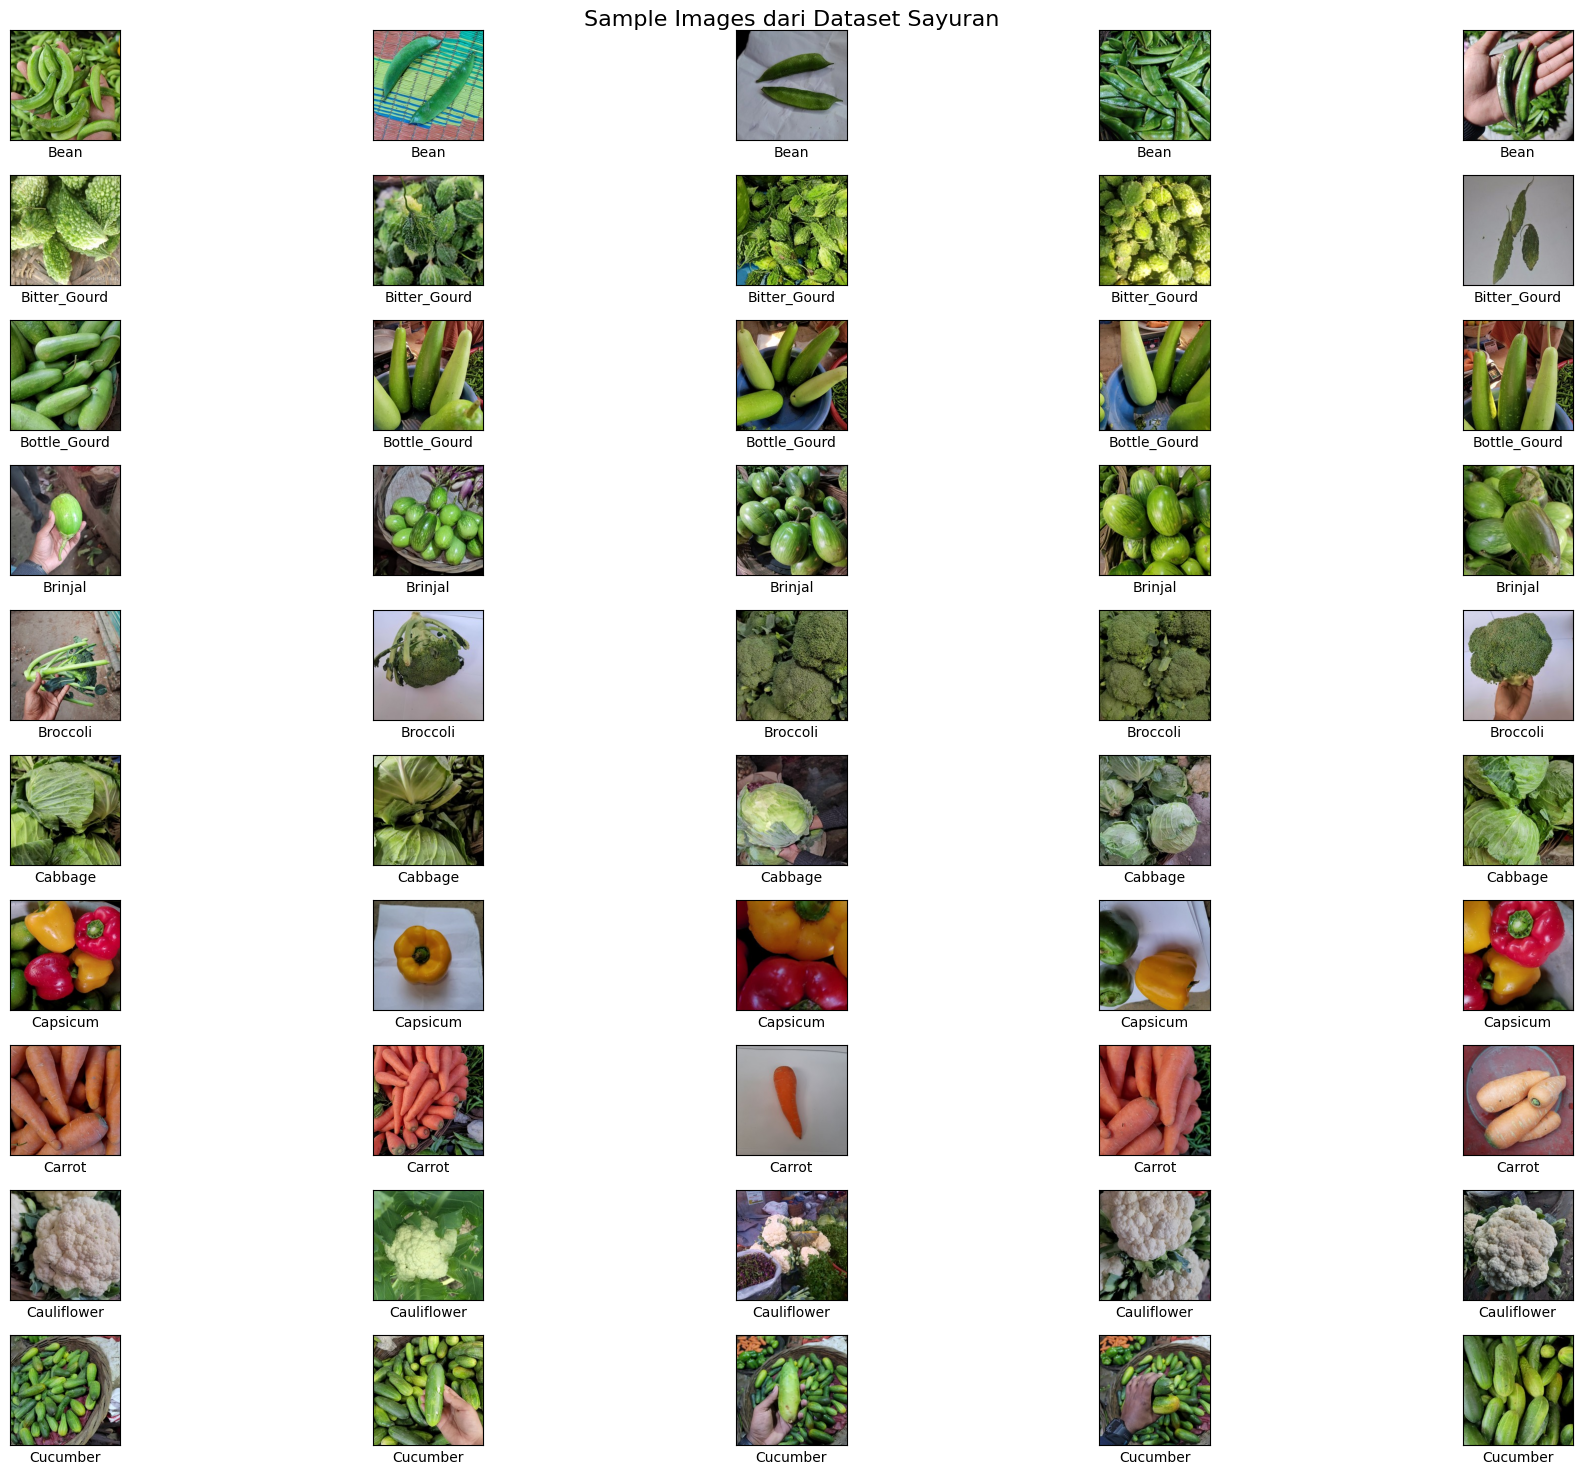

Informasi Dataset:
Bean: 1200 gambar
Bitter_Gourd: 1200 gambar
Bottle_Gourd: 1200 gambar
Brinjal: 1200 gambar
Broccoli: 1200 gambar
Cabbage: 1200 gambar
Capsicum: 1200 gambar
Carrot: 1200 gambar
Cauliflower: 1200 gambar
Cucumber: 1200 gambar


In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data  
vegetable_images = {}  
   
# Tentukan path sumber train  
path = r"D:\UB\Dicoding\Datasets\vegetable"  
path_sub = os.path.join(path, "dataset")  

# Membuat kamus dengan daftar gambar untuk setiap kelas  
for class_name in os.listdir(path_sub):  
    vegetable_images[class_name] = os.listdir(os.path.join(path_sub, class_name))  
   
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data  
fig, axs = plt.subplots(len(vegetable_images.keys()), 5, figsize=(20, 15))  
   
for i, class_name in enumerate(os.listdir(path_sub)):  
    # Pilih 5 gambar acak dari kelas tersebut  
    images = np.random.choice(vegetable_images[class_name], 5, replace=False)  
   
    for j, image_name in enumerate(images):  
        img_path = os.path.join(path_sub, class_name, image_name)  
        img = Image.open(img_path)  # Buka gambar dalam warna asli  
        axs[i, j].imshow(img)  
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])  
   
fig.suptitle('Sample Images dari Dataset Sayuran', fontsize=16)  
fig.tight_layout()  
plt.show()  

# Cetak informasi jumlah gambar per kelas  
print("Informasi Dataset:")  
for class_name, images in vegetable_images.items():  
    print(f"{class_name}: {len(images)} gambar")  

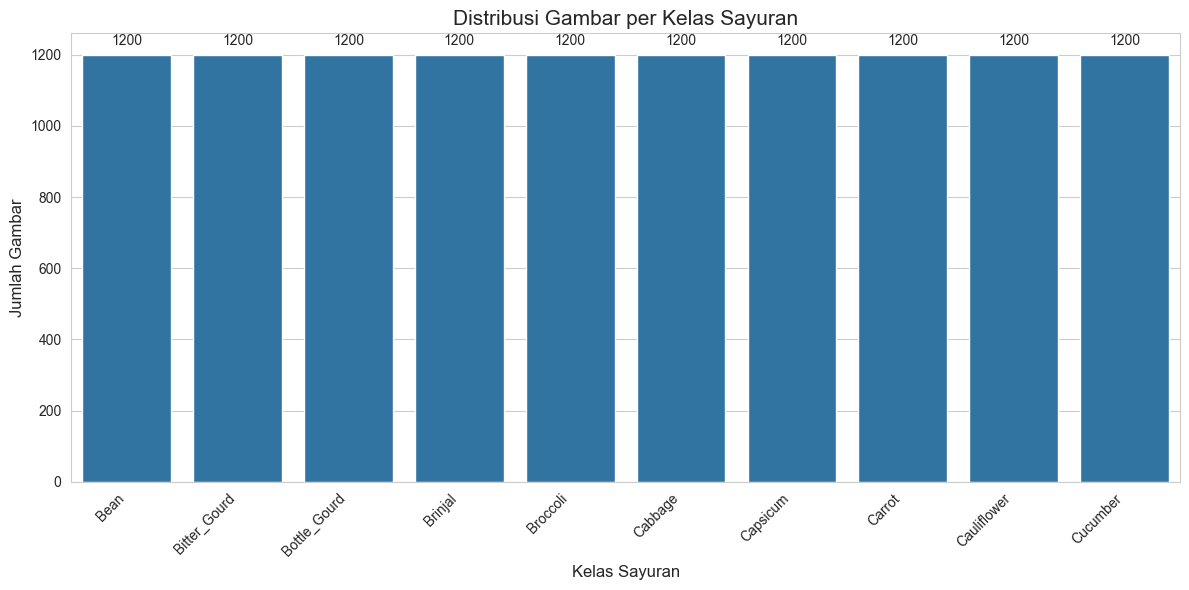


Detail Distribusi Dataset:
labels
Bean            1200
Bitter_Gourd    1200
Bottle_Gourd    1200
Brinjal         1200
Broccoli        1200
Cabbage         1200
Capsicum        1200
Carrot          1200
Cauliflower     1200
Cucumber        1200
Name: count, dtype: int64

Total Gambar Keseluruhan: 12000


In [6]:
# Definisikan path sumber dataset  
vegetable_path = r"D:\UB\Dicoding\Datasets\vegetable\dataset"  

# Buat list untuk menyimpan data  
file_name = []  
labels = []  
full_path = []  

# Dapatkan nama file gambar, path file, dan label  
for path, subdirs, files in os.walk(vegetable_path):  
    for name in files:  
        # Hindari file system atau hidden files  
        if not name.startswith('.'):  
            full_path.append(os.path.join(path, name))  
            # Ambil nama kelas dari path terakhir  
            labels.append(os.path.basename(path))  
            file_name.append(name)  

# Buat DataFrame  
distribution_train = pd.DataFrame({  
    "path": full_path,   
    'file_name': file_name,   
    "labels": labels  
})  

# Plot distribusi gambar di setiap kelas  
plt.figure(figsize=(12, 6))  
sns.set_style("whitegrid")  

# Gunakan countplot untuk menampilkan distribusi  
plot_data = sns.countplot(  
    x='labels',   
    data=distribution_train,   
    order=distribution_train['labels'].value_counts().index  
)  

# Rotasi label untuk kemudahan membaca  
plt.xticks(rotation=45, ha='right')  
plt.title('Distribusi Gambar per Kelas Sayuran', fontsize=15)  
plt.xlabel('Kelas Sayuran', fontsize=12)  
plt.ylabel('Jumlah Gambar', fontsize=12)  

# Tambahkan jumlah gambar di atas setiap bar  
for p in plot_data.patches:  
    plot_data.annotate(f'{int(p.get_height())}',   
                       (p.get_x() + p.get_width() / 2., p.get_height()),  
                       ha='center', va='center',   
                       xytext=(0, 10), textcoords='offset points')  

plt.tight_layout()  
plt.show()  

# Cetak detail distribusi  
print("\nDetail Distribusi Dataset:")  
distribution_summary = distribution_train['labels'].value_counts()  
print(distribution_summary)  

# Hitung total gambar  
total_images = len(distribution_train)  
print(f"\nTotal Gambar Keseluruhan: {total_images}")  

### Data Preprocessing

#### Split Dataset

In [7]:
# Path dataset  
mypath = r"D:\UB\Dicoding\Datasets\vegetable\dataset"  

# Inisialisasi list untuk menyimpan informasi  
file_name = []  
labels = []  
full_path = []  

# Kumpulkan informasi gambar  
for path, subdirs, files in os.walk(mypath):  
    for name in files:  
        # Hindari file system atau hidden files  
        if not name.startswith('.'):  
            full_path.append(os.path.join(path, name))  
            labels.append(os.path.basename(path))  
            file_name.append(name)  

# Buat DataFrame  
df = pd.DataFrame({  
    "path": full_path,  
    'file_name': file_name,  
    "labels": labels  
})  

# Tampilkan jumlah data per label  
print("Distribusi Data per Label:")  
print(df.groupby(['labels']).size())  

# Siapkan variabel untuk splitting  
X = df['path']  
y = df['labels']  

# Lakukan pembagian data  
X_train, X_test, y_train, y_test = train_test_split(  
    X, y, test_size=0.2, random_state=42  
)  

# Buat DataFrame terpisah untuk train dan test  
df_tr = pd.DataFrame({  
    'path': X_train,   
    'labels': y_train,   
    'set': 'train'  
})  
df_te = pd.DataFrame({  
    'path': X_test,   
    'labels': y_test,   
    'set': 'test'  
})  

# Gabungkan DataFrame  
df_all = pd.concat([df_tr, df_te], ignore_index=True)  

# Tampilkan distribusi data train dan test  
print("\nDistribusi Data Train dan Test:")  
print(df_all.groupby(['set', 'labels']).size())  

# Path untuk dataset final  
datasource_path = r"D:\UB\Dicoding\Datasets\vegetable\dataset"  
dataset_path = r"D:\UB\Dicoding\Datasets\vegetable\Dataset-Final"  

# Buat direktori dataset final jika belum ada  
os.makedirs(dataset_path, exist_ok=True)  

# Salin file ke struktur direktori baru  
for index, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):  
    # Deteksi filepath  
    file_path = row['path']  
    
    # Buat direktori tujuan  
    set_path = os.path.join(dataset_path, row['set'])  
    label_path = os.path.join(set_path, row['labels'])  
    os.makedirs(label_path, exist_ok=True)  
    
    # Tentukan nama file tujuan  
    destination_file_name = os.path.basename(file_path)  
    file_dest = os.path.join(label_path, destination_file_name)  
    
    # Salin file  
    shutil.copy2(file_path, file_dest)  

print("\nPemindahan file selesai!")  

# Verifikasi struktur direktori baru  
print("\nStruktur Direktori Baru:")  
for root, dirs, files in os.walk(dataset_path):  
    level = root.replace(dataset_path, '').count(os.sep)  
    indent = ' ' * 4 * (level)  
    print(f"{indent}{os.path.basename(root)}/")  

Distribusi Data per Label:
labels
Bean            1200
Bitter_Gourd    1200
Bottle_Gourd    1200
Brinjal         1200
Broccoli        1200
Cabbage         1200
Capsicum        1200
Carrot          1200
Cauliflower     1200
Cucumber        1200
dtype: int64

Distribusi Data Train dan Test:
set    labels      
test   Bean            246
       Bitter_Gourd    239
       Bottle_Gourd    252
       Brinjal         254
       Broccoli        245
       Cabbage         225
       Capsicum        235
       Carrot          225
       Cauliflower     245
       Cucumber        234
train  Bean            954
       Bitter_Gourd    961
       Bottle_Gourd    948
       Brinjal         946
       Broccoli        955
       Cabbage         975
       Capsicum        965
       Carrot          975
       Cauliflower     955
       Cucumber        966
dtype: int64


100%|██████████| 12000/12000 [02:23<00:00, 83.85it/s] 


Pemindahan file selesai!

Struktur Direktori Baru:
Dataset-Final/
    test/
        Bean/
        Bitter_Gourd/
        Bottle_Gourd/
        Brinjal/
        Broccoli/
        Cabbage/
        Capsicum/
        Carrot/
        Cauliflower/
        Cucumber/
    train/
        Bean/
        Bitter_Gourd/
        Bottle_Gourd/
        Brinjal/
        Broccoli/
        Cabbage/
        Capsicum/
        Carrot/
        Cauliflower/
        Cucumber/


#### Image Data Generator

In [8]:
# Definisikan direktori training dan test  
TRAIN_DIR = r"D:\UB\Dicoding\Datasets\vegetable\Dataset-Final\train"  
TEST_DIR = r"D:\UB\Dicoding\Datasets\vegetable\Dataset-Final\test"  

# Fungsi untuk menghitung jumlah gambar per kelas  
def count_images_per_class(directory):  
    class_counts = {}  
    for class_name in os.listdir(directory):  
        class_path = os.path.join(directory, class_name)  
        class_counts[class_name] = len(os.listdir(class_path))  
    return class_counts  

# Hitung jumlah gambar di training set  
print("Jumlah Gambar per Kelas di Training Set:")  
train_counts = count_images_per_class(TRAIN_DIR)  
for class_name, count in train_counts.items():  
    print(f"{class_name}: {count} gambar")  

# Hitung jumlah gambar di test set  
print("\nJumlah Gambar per Kelas di Test Set:")  
test_counts = count_images_per_class(TEST_DIR)  
for class_name, count in test_counts.items():  
    print(f"{class_name}: {count} gambar")  

# Konfigurasi Image Data Generator dengan augmentasi  
train_datagen = ImageDataGenerator(  
    rescale=1./255,  # Normalisasi piksel  
    rotation_range=20,  # Rotasi acak hingga 20 derajat  
    width_shift_range=0.2,  # Pergeseran horizontal  
    height_shift_range=0.2,  # Pergeseran vertikal  
    shear_range=0.2,  # Transformasi shear  
    zoom_range=0.2,  # Zoom acak  
    horizontal_flip=True,  # Flip horizontal  
    fill_mode='nearest',  # Mode pengisian untuk transformasi  
    validation_split=0.2  # Gunakan 20% data untuk validasi  
)  

# Data Generator untuk test (hanya rescale)  
test_datagen = ImageDataGenerator(rescale=1./255)  

# Generator untuk training set  
train_generator = train_datagen.flow_from_directory(  
    TRAIN_DIR,  
    target_size=(224, 224),  # Ubah ukuran gambar  
    batch_size=32,  # Ukuran batch  
    class_mode='categorical',  # Mode klasifikasi multi-kelas  
    subset='training',  # Subset training  
    shuffle=True,  # Acak urutan gambar  
    seed=42  # Seed untuk reproduktibilitas  
)  

# Generator untuk validation set  
validation_generator = train_datagen.flow_from_directory(  
    TRAIN_DIR,  
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='categorical',  
    subset='validation',  
    shuffle=False,  
    seed=42  
)  

# Generator untuk test set  
test_generator = test_datagen.flow_from_directory(  
    TEST_DIR,  
    target_size=(224, 224),  
    batch_size=32,  
    class_mode='categorical',  
    shuffle=False  
)  

# Cetak informasi label  
print("\nInformasi Label:")  
print("Indeks Label:", train_generator.class_indices)  
print("Nama Label:", list(train_generator.class_indices.keys()))  

# Hitung total jumlah gambar  
print("\nTotal Jumlah Gambar:")  
print(f"Training: {train_generator.samples}")  
print(f"Validation: {validation_generator.samples}")  
print(f"Testing: {test_generator.samples}")  

Jumlah Gambar per Kelas di Training Set:
Bean: 954 gambar
Bitter_Gourd: 961 gambar
Bottle_Gourd: 948 gambar
Brinjal: 946 gambar
Broccoli: 955 gambar
Cabbage: 975 gambar
Capsicum: 965 gambar
Carrot: 975 gambar
Cauliflower: 955 gambar
Cucumber: 966 gambar

Jumlah Gambar per Kelas di Test Set:
Bean: 246 gambar
Bitter_Gourd: 239 gambar
Bottle_Gourd: 252 gambar
Brinjal: 254 gambar
Broccoli: 245 gambar
Cabbage: 225 gambar
Capsicum: 235 gambar
Carrot: 225 gambar
Cauliflower: 245 gambar
Cucumber: 234 gambar
Found 7682 images belonging to 10 classes.
Found 1918 images belonging to 10 classes.
Found 2400 images belonging to 10 classes.

Informasi Label:
Indeks Label: {'Bean': 0, 'Bitter_Gourd': 1, 'Bottle_Gourd': 2, 'Brinjal': 3, 'Broccoli': 4, 'Cabbage': 5, 'Capsicum': 6, 'Carrot': 7, 'Cauliflower': 8, 'Cucumber': 9}
Nama Label: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber']

Total Jumlah Gambar:
Training: 7682
Validat

## Modelling

In [12]:
# Tentukan parameter model  
input_shape = (224, 224, 3)  
num_classes = len(train_generator.class_indices)  

# Custom callback untuk menghentikan training saat akurasi >= 95%  
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):  
    def __init__(self, threshold=0.95):  
        super().__init__()  
        self.threshold = threshold  

    def on_epoch_end(self, epoch, logs=None):  
        val_accuracy = logs.get('val_accuracy')  
        if val_accuracy is not None and val_accuracy >= self.threshold:  
            print(f"\nReached {self.threshold*100}% validation accuracy. Stopping training.")  
            self.model.stop_training = True  

# Fungsi untuk membuat model CNN  
def create_vegetable_cnn_model(input_shape, num_classes):  
    model = Sequential([  
        # Layer Konvolusi Pertama  
        Conv2D(32, (3, 3), padding='same', activation='relu',   
               input_shape=input_shape),  
        BatchNormalization(),  
        MaxPooling2D((2, 2)),  
        
        # Layer Konvolusi Kedua  
        Conv2D(64, (3, 3), padding='same', activation='relu'),  
        BatchNormalization(),  
        MaxPooling2D((2, 2)),  
        
        # Layer Konvolusi Ketiga  
        Conv2D(128, (3, 3), padding='same', activation='relu'),  
        BatchNormalization(),  
        MaxPooling2D((2, 2)),  
        
        # Flatten Layer  
        Flatten(),  
        
        # Dense Layer Pertama  
        Dense(256, activation='relu'),  
        Dropout(0.5),  
        
        # Dense Layer Kedua  
        Dense(128, activation='relu'),  
        Dropout(0.4),  
        
        # Output Layer  
        Dense(num_classes, activation='softmax')  
    ])  
    
    return model  

In [13]:
# Hitung class weights untuk menangani ketidakseimbangan kelas  
def calculate_class_weights(generator):  
    class_weights = {}  
    total_samples = generator.samples  
    num_classes = len(generator.class_indices)  
    
    # Hitung jumlah sampel per kelas  
    class_counts = [0] * num_classes  
    for i in range(total_samples):  
        class_idx = generator.classes[i]  
        class_counts[class_idx] += 1  
    
    # Hitung bobot untuk setiap kelas  
    for i in range(num_classes):  
        class_weights[i] = total_samples / (num_classes * class_counts[i])  
    
    return class_weights  

# Hitung class weights  
class_weights = calculate_class_weights(train_generator)  

In [14]:
# Callback untuk early stopping dan learning rate  
early_stopping = EarlyStopping(  
    monitor='val_accuracy',  
    mode='max',  
    patience=5,  
    min_delta=0.01,  
    restore_best_weights=True,  
    verbose=1  
)  

reduce_lr = ReduceLROnPlateau(  
    monitor='val_accuracy',   
    factor=0.2,  
    patience=3,  
    min_lr=1e-6,  
    verbose=1  
)  

# Gabungkan callback  
callbacks = [  
    early_stopping,  
    reduce_lr,  
    AccuracyThresholdCallback(threshold=0.95)  
]  

# Inisialisasi dan kompilasi model  
model = create_vegetable_cnn_model(input_shape, num_classes)  
model.compile(  
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)  

# Tampilkan ringkasan model  
model.summary()  

# Training model  
history = model.fit(  
    train_generator,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  
    epochs=100,  
    validation_data=validation_generator,  
    validation_steps=validation_generator.samples // validation_generator.batch_size,  
    class_weight=class_weights,  
    callbacks=callbacks  
)  

# Cetak epoch terakhir  
print(f"\nTraining berhenti pada epoch ke-{len(history.history['accuracy'])}")  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                      

## Evaluasi dan Visualisasi

75/75 [==============================] - 38s 511ms/step - loss: 0.1758 - accuracy: 0.9613

Test Loss: 0.17580994963645935
Test Accuracy: 0.9612500071525574


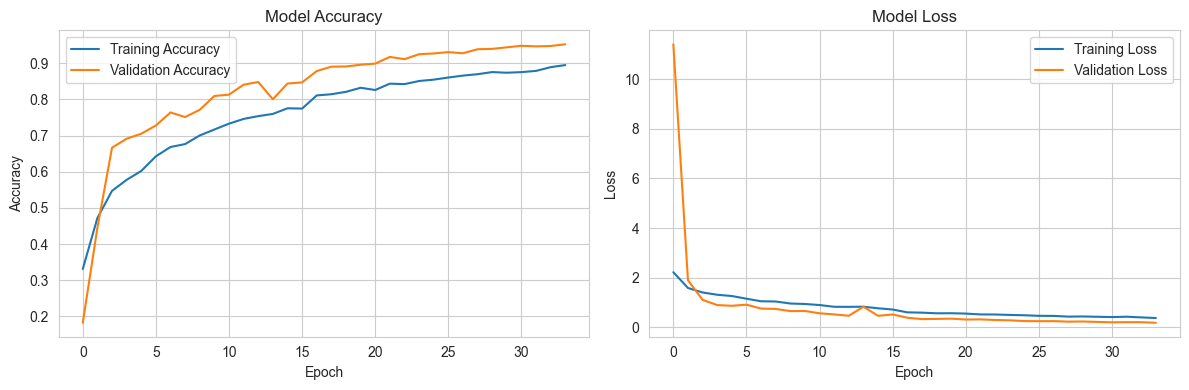

In [15]:
# Evaluasi model pada test set  
test_loss, test_accuracy = model.evaluate(test_generator)  
print(f"\nTest Loss: {test_loss}")  
print(f"Test Accuracy: {test_accuracy}")  

# Fungsi plot training history  
def plot_training_history(history):  
    plt.figure(figsize=(12, 4))  
    
    # Plot akurasi  
    plt.subplot(1, 2, 1)  
    plt.plot(history.history['accuracy'], label='Training Accuracy')  
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
    plt.title('Model Accuracy')  
    plt.xlabel('Epoch')  
    plt.ylabel('Accuracy')  
    plt.legend()  

    # Plot loss  
    plt.subplot(1, 2, 2)  
    plt.plot(history.history['loss'], label='Training Loss')  
    plt.plot(history.history['val_loss'], label='Validation Loss')  
    plt.title('Model Loss')  
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')  
    plt.legend()  

    plt.tight_layout()  
    plt.show()  

# Panggil fungsi plot  
plot_training_history(history)  

## Konversi Model

In [ ]:
# Simpan model  
model.save('savedvegetable_classification_model.h5')  
print("\nModel telah disimpan.")  

d:\UB\Dicoding\GitHub\Dicoding_Akmal\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model telah disimpan.


In [17]:
# Direktori untuk menyimpan model  
SAVED_MODEL_DIR = 'submission'  
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)  


In [37]:
import tensorflow as tf
import json
print(tf.__version__)


2.15.0


In [19]:
# 1. Simpan dalam format SavedModel  
def save_saved_model(model):  
    saved_model_path = os.path.join(SAVED_MODEL_DIR, 'saved_model')  
    os.makedirs(saved_model_path, exist_ok=True)  
    model.save(saved_model_path, save_format='tf')  
    print(f"Model SavedModel disimpan di: {saved_model_path}")  

In [20]:
# 2. Konversi dan simpan dalam format TF-Lite  
def convert_to_tflite(model, test_generator):  
    # Direktori TF-Lite  
    tflite_dir = os.path.join(SAVED_MODEL_DIR, 'tflite')  
    os.makedirs(tflite_dir, exist_ok=True)  
    
    # Konversi model ke TF-Lite  
    converter = tf.lite.TFLiteConverter.from_keras_model(model)  
    
    # Optimasi model  
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  
    converter.target_spec.supported_types = [tf.float16]  
    
    # Konversi model  
    tflite_model = converter.convert()  
    
    # Simpan model TF-Lite  
    tflite_path = os.path.join(tflite_dir, 'model.tflite')  
    with open(tflite_path, 'wb') as f:  
        f.write(tflite_model)  
    
    # Simpan label  
    labels = list(test_generator.class_indices.keys())  
    label_path = os.path.join(tflite_dir, 'label.txt')  
    with open(label_path, 'w') as f:  
        f.write('\n'.join(labels))  
    
    print(f"Model TF-Lite disimpan di: {tflite_path}")  
    print(f"Label disimpan di: {label_path}")  
    
    return tflite_model, labels  


In [ ]:
import tensorflowjs as tfjs
# 3. Konversi dan simpan dalam format TensorFlow.js  
def convert_to_tfjs(model):  
    # Direktori TFJS  
    tfjs_path = os.path.join(SAVED_MODEL_DIR, 'tfjs_model')  
    os.makedirs(tfjs_path, exist_ok=True)  
    
    # Konversi dan simpan model  
    tfjs.converters.save_keras_model(model, tfjs_path)  
    print(f"Model TensorFlow.js disimpan di: {tfjs_path}")  

In [42]:
# 4. Fungsi untuk membuat contoh prediksi dan dokumentasi  
def create_model_documentation(model, test_generator, labels):  
    # Direktori dokumentasi  
    doc_dir = os.path.join(SAVED_MODEL_DIR, 'documentation')  
    os.makedirs(doc_dir, exist_ok=True)  
    
    # Ambil informasi model  
    model_info = {  
        'model_name': 'Vegetable Classification Model',  
        'input_shape': model.input_shape,  
        'output_classes': labels,  
        'total_params': model.count_params(),  
        'layers': [layer.name for layer in model.layers]  
    }  
    
    # Simpan informasi model dalam JSON  
    model_info_path = os.path.join(doc_dir, 'model_info.json')  
    with open(model_info_path, 'w') as f:  
        json.dump(model_info, f, indent=4)  
    
    # Contoh prediksi  
    test_images, test_labels = next(test_generator)  
    predictions = model.predict(test_images)  
    
    # Simpan contoh prediksi  
    prediction_examples = []  
    for i in range(min(5, len(test_images))):  
        pred_class = labels[np.argmax(predictions[i])]  
        true_class = labels[np.argmax(test_labels[i])]  
        prediction_examples.append({  
            'image_index': i,  
            'predicted_class': pred_class,  
            'true_class': true_class  
        })  
    
    # Simpan contoh prediksi  
    pred_examples_path = os.path.join(doc_dir, 'prediction_examples.json')  
    with open(pred_examples_path, 'w') as f:  
        json.dump(prediction_examples, f, indent=4)  
    
    print(f"Dokumentasi model disimpan di: {doc_dir}")  


In [23]:
# Jalankan konversi dan simpan model  
def main():  
    # Pastikan model sudah dilatih sebelumnya  
    # Simpan dalam format SavedModel  
    save_saved_model(model)  
    
    # Konversi ke TF-Lite  
    tflite_model, labels = convert_to_tflite(model, test_generator)  
    
    # Konversi ke TensorFlow.js  
    convert_to_tfjs(model)  
    
    # Buat dokumentasi model  
    create_model_documentation(model, test_generator, labels)  

In [38]:
# Jalankan fungsi utama  
if __name__ == '__main__':  
    main()  

INFO:tensorflow:Assets written to: submission\saved_model\assets


INFO:tensorflow:Assets written to: submission\saved_model\assets


Model SavedModel disimpan di: submission\saved_model
INFO:tensorflow:Assets written to: C:\Users\akmal\AppData\Local\Temp\tmpllr0hwtf\assets


INFO:tensorflow:Assets written to: C:\Users\akmal\AppData\Local\Temp\tmpllr0hwtf\assets


Model TF-Lite disimpan di: submission\tflite\model.tflite
Label disimpan di: submission\tflite\label.txt


NameError: name 'tfjs' is not defined

## Inference (Optional)